In [59]:
from numpy.random import seed
seed(101)

import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras.optimizers import SGD, RMSprop, Adam, Adadelta
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Activation, AvgPool2D, MaxPool2D, Dropout, Conv2D, MaxPooling2D, Flatten, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.metrics import binary_accuracy
from tensorflow.keras.applications import DenseNet169, MobileNet, NASNetMobile, Xception, InceptionV3
from tensorflow.keras import regularizers

import os
import cv2

import imageio
import skimage
import skimage.io
import skimage.transform

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt
%matplotlib inline

# Set random seed for TensorFlow
tf.random.set_seed(101)


In [60]:
# Total number of images we want to have in each class
NUM_AUG_IMAGES_WANTED = 1500

# We will resize the images
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Total number of images we want to have in each class
NUM_AUG_IMAGES_WANTED = 1500

# We will resize the images
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224

In [8]:
os.listdir('/content/drive/MyDrive/archive')

['ChinaSet_AllFiles', 'Montgomery']

In [19]:
print(len(os.listdir('/content/drive/MyDrive/archive/ChinaSet_AllFiles/ChinaSet_AllFiles/CXR_png')))
print(len(os.listdir('/content/drive/MyDrive/archive/Montgomery/MontgomerySet/CXR_png')))

663
139


In [20]:
shen_image_list = os.listdir('/content/drive/MyDrive/archive/ChinaSet_AllFiles/ChinaSet_AllFiles/CXR_png')
mont_image_list = os.listdir('/content/drive/MyDrive/archive/Montgomery/MontgomerySet/CXR_png')

In [21]:
# put the images into dataframes
df_shen = pd.DataFrame(shen_image_list, columns=['image_id'])
df_mont = pd.DataFrame(mont_image_list, columns=['image_id'])

# remove the 'Thunbs.db' line
df_shen = df_shen[df_shen['image_id'] != 'Thumbs.db']
df_mont = df_mont[df_mont['image_id'] != 'Thumbs.db']

# Reset the index or this will cause an error later
df_shen.reset_index(inplace=True, drop=True)
df_mont.reset_index(inplace=True, drop=True)

print(df_shen.shape)
print(df_mont.shape)

(662, 1)
(138, 1)


In [22]:
df_shen.head()

,image_id
0,CHNCXR_0138_0.png
1,CHNCXR_0275_0.png
2,CHNCXR_0282_0.png
3,CHNCXR_0260_0.png
4,CHNCXR_0262_0.png


In [23]:
df_mont.head()

,image_id
0,MCUCXR_0022_0.png
1,MCUCXR_0059_0.png
2,MCUCXR_0031_0.png
3,MCUCXR_0051_0.png
4,MCUCXR_0017_0.png


In [24]:
# Function to select the 4th index from the end of the string (file name)
# example: CHNCXR_0470_1.png --> 1 is the label, meaning TB is present.

def extract_target(x):
    target = int(x[-5])
    if target == 0:
        return 'Normal'
    if target == 1:
        return 'Tuberculosis'

In [25]:
# Assign the target labels

df_shen['target'] = df_shen['image_id'].apply(extract_target)

df_mont['target'] = df_mont['image_id'].apply(extract_target)

In [26]:
# Shenzen Dataset

df_shen['target'].value_counts()

target
Tuberculosis    336
Normal          326
Name: count, dtype: int64

In [27]:
# Montgomery Dataset

df_mont['target'].value_counts()

target
Normal          80
Tuberculosis    58
Name: count, dtype: int64

In [28]:
def draw_category_images(col_name,figure_cols, df, IMAGE_PATH):

    """
    Give a column in a dataframe,
    this function takes a sample of each class and displays that
    sample on one row. The sample size is the same as figure_cols which
    is the number of columns in the figure.
    Because this function takes a random sample, each time the function is run it
    displays different images.
    """


    categories = (df.groupby([col_name])[col_name].nunique()).index
    f, ax = plt.subplots(nrows=len(categories),ncols=figure_cols,
                         figsize=(4*figure_cols,4*len(categories))) # adjust size here
    # draw a number of images for each location
    for i, cat in enumerate(categories):
        sample = df[df[col_name]==cat].sample(figure_cols) # figure_cols is also the sample size
        for j in range(0,figure_cols):
            file=IMAGE_PATH + sample.iloc[j]['image_id']
            im=imageio.imread(file)
            ax[i, j].imshow(im, resample=True, cmap='gray')
            ax[i, j].set_title(cat, fontsize=14)
    plt.tight_layout()
    plt.show()

<ipython-input-28-7a59a8a5a1c0>:21: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im=imageio.imread(file)


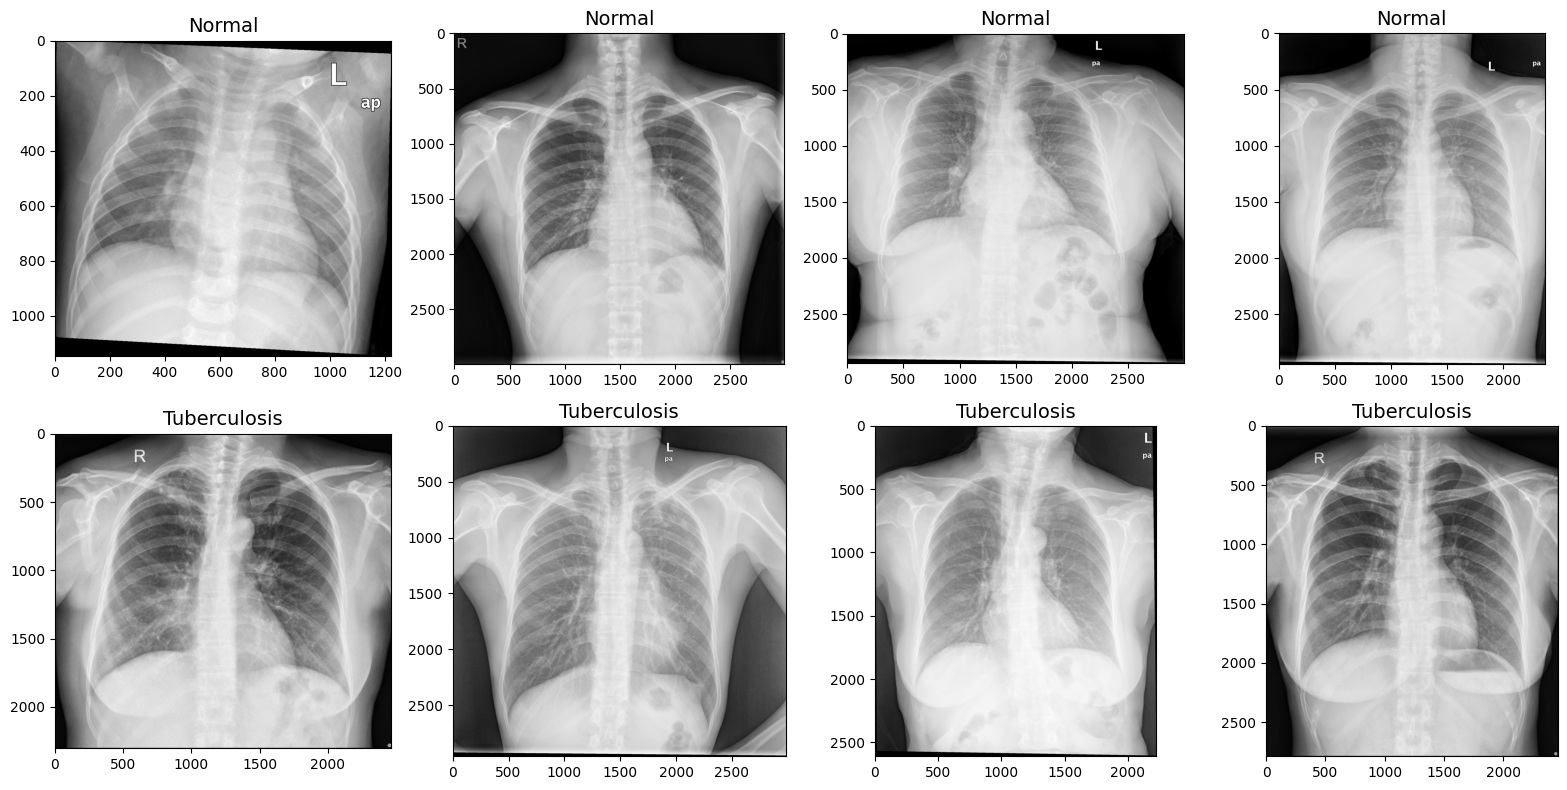

In [29]:
# Shenzen Dataset

IMAGE_PATH = '/content/drive/MyDrive/archive/ChinaSet_AllFiles/ChinaSet_AllFiles/CXR_png/'

draw_category_images('target',4, df_shen, IMAGE_PATH)

<ipython-input-28-7a59a8a5a1c0>:21: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im=imageio.imread(file)


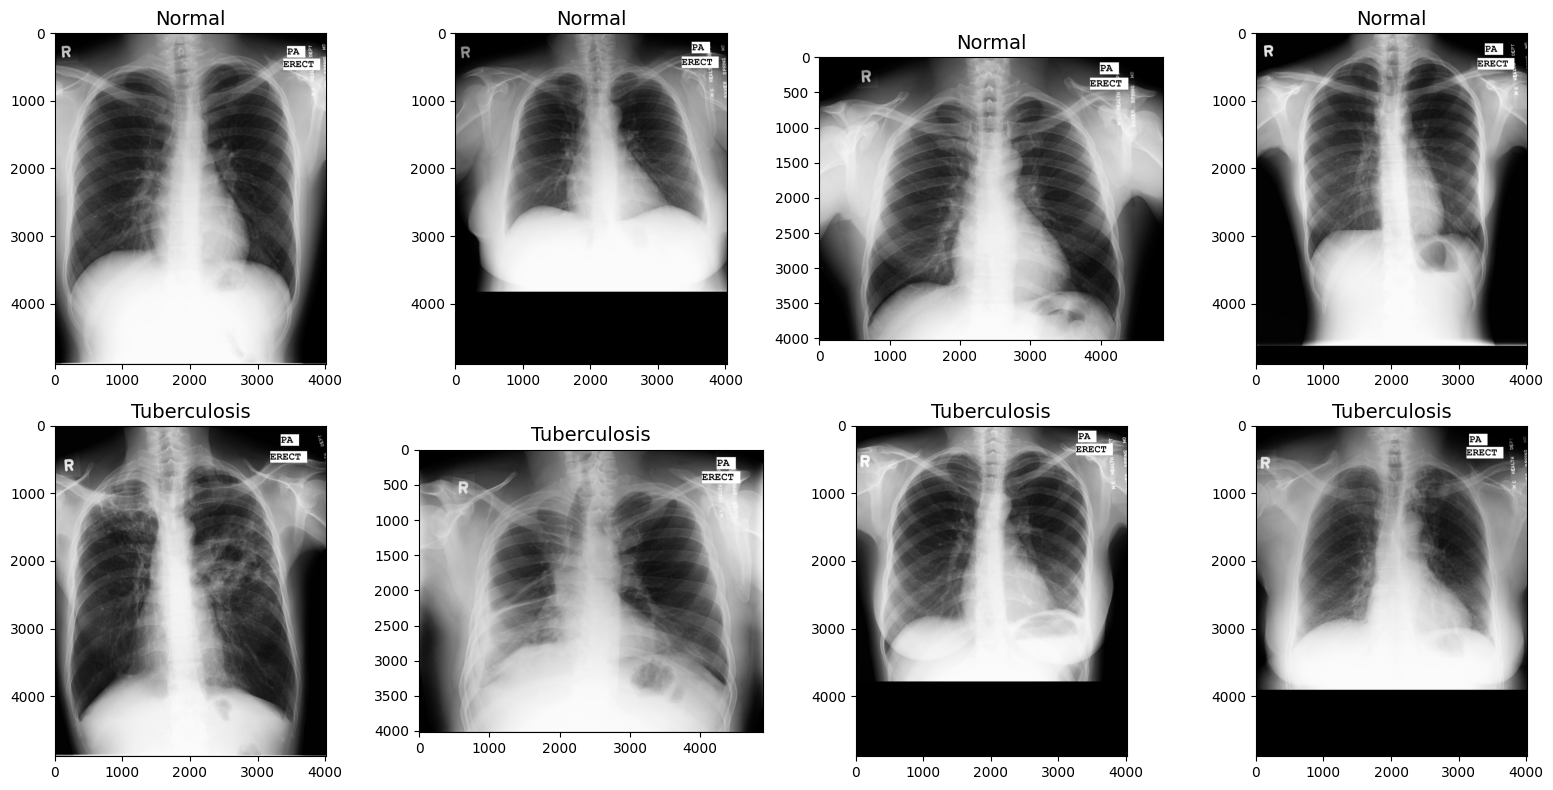

In [30]:
# Montgomery Dataset

IMAGE_PATH = '/content/drive/MyDrive/archive/Montgomery/MontgomerySet/CXR_png/'

draw_category_images('target',4, df_mont, IMAGE_PATH)

In [31]:
def read_image_sizes(file_name):
    """
    1. Get the shape of the image
    2. Get the min and max pixel values in the image.
    Getting pixel values will tell if any pre-processing has been done.
    3. This info will be added to the original dataframe.
    """
    image = cv2.imread(IMAGE_PATH + file_name)
    max_pixel_val = image.max()
    min_pixel_val = image.min()

    # image.shape[2] represents the number of channels: (height, width, num_channels).
    # Here we are saying: If the shape does not have a value for num_channels (height, width)
    # then assign 1 to the number of channels.
    if len(image.shape) > 2: # i.e. more than two numbers in the tuple
        output = [image.shape[0], image.shape[1], image.shape[2], max_pixel_val, min_pixel_val]
    else:
        output = [image.shape[0], image.shape[1], 1, max_pixel_val, min_pixel_val]
    return output

In [32]:
IMAGE_PATH = '/content/drive/MyDrive/archive/ChinaSet_AllFiles/ChinaSet_AllFiles/CXR_png/'

m = np.stack(df_shen['image_id'].apply(read_image_sizes))
df = pd.DataFrame(m,columns=['w','h','c','max_pixel_val','min_pixel_val'])
df_shen = pd.concat([df_shen,df],axis=1, sort=False)

df_shen.head()

,image_id,target,w,h,c,max_pixel_val,min_pixel_val
0,CHNCXR_0138_0.png,Normal,2943,3000,3,255,0
1,CHNCXR_0275_0.png,Normal,2994,2992,3,255,0
2,CHNCXR_0282_0.png,Normal,2967,3000,3,255,0
3,CHNCXR_0260_0.png,Normal,2935,3000,3,255,0
4,CHNCXR_0262_0.png,Normal,2937,3000,3,255,0


In [33]:
IMAGE_PATH = '/content/drive/MyDrive/archive/Montgomery/MontgomerySet/CXR_png/'

m = np.stack(df_mont['image_id'].apply(read_image_sizes))
df = pd.DataFrame(m,columns=['w','h','c','max_pixel_val','min_pixel_val'])
df_mont = pd.concat([df_mont,df],axis=1, sort=False)

df_mont.head()

,image_id,target,w,h,c,max_pixel_val,min_pixel_val
0,MCUCXR_0022_0.png,Normal,4020,4892,3,255,0
1,MCUCXR_0059_0.png,Normal,4892,4020,3,255,0
2,MCUCXR_0031_0.png,Normal,4020,4892,3,255,0
3,MCUCXR_0051_0.png,Normal,4892,4020,3,255,0
4,MCUCXR_0017_0.png,Normal,4020,4892,3,255,0


In [34]:
df_shen['c'].value_counts()

c
3    662
Name: count, dtype: int64

In [35]:
df_mont['c'].value_counts()

c
3    138
Name: count, dtype: int64

In [36]:
df_mont['target'].value_counts()

target
Normal          80
Tuberculosis    58
Name: count, dtype: int64

In [37]:
### Combine the two dataframes and shuffle

df_data = pd.concat([df_shen, df_mont], axis=0).reset_index(drop=True)

df_data = shuffle(df_data)


df_data.shape

(800, 7)

In [38]:
# Create a new column called 'labels' that maps the classes to binary values.
df_data['labels'] = df_data['target'].map({'Normal':0, 'Tuberculosis':1})

In [39]:
df_data.head()

,image_id,target,w,h,c,max_pixel_val,min_pixel_val,labels
679,MCUCXR_0004_0.png,Normal,4892,4020,3,255,0,0
177,CHNCXR_0126_0.png,Normal,2933,2997,3,255,0,0
60,CHNCXR_0009_0.png,Normal,2942,2516,3,255,0,0
782,MCUCXR_0309_1.png,Tuberculosis,4892,4020,3,255,0,1
667,MCUCXR_0040_0.png,Normal,4892,4020,3,255,0,0


In [40]:
# train_test_split

y = df_data['labels']

df_train, df_val = train_test_split(df_data, test_size=0.15, random_state=101, stratify=y)

print(df_train.shape)
print(df_val.shape)

(680, 8)
(120, 8)


In [41]:
df_train['target'].value_counts()

target
Normal          345
Tuberculosis    335
Name: count, dtype: int64

In [42]:
df_val['target'].value_counts()

target
Normal          61
Tuberculosis    59
Name: count, dtype: int64

In [43]:
# Create a new directory
base_dir = 'base_dir'
os.mkdir(base_dir)


#[CREATE FOLDERS INSIDE THE BASE DIRECTORY]

# now we create 2 folders inside 'base_dir':

# train
    # Normal
    # Tuberculosis

# val
    # Normal
    # Tuberculosis


# create a path to 'base_dir' to which we will join the names of the new folders
# train_dir
train_dir = os.path.join(base_dir, 'train_dir')
os.mkdir(train_dir)

# val_dir
val_dir = os.path.join(base_dir, 'val_dir')
os.mkdir(val_dir)


# [CREATE FOLDERS INSIDE THE TRAIN AND VALIDATION FOLDERS]
# Inside each folder we create seperate folders for each class

# create new folders inside train_dir
Normal = os.path.join(train_dir, 'Normal')
os.mkdir(Normal)
Tuberculosis = os.path.join(train_dir, 'Tuberculosis')
os.mkdir(Tuberculosis)


# create new folders inside val_dir
Normal = os.path.join(val_dir, 'Normal')
os.mkdir(Normal)
Tuberculosis = os.path.join(val_dir, 'Tuberculosis')
os.mkdir(Tuberculosis)

In [44]:
# Set the image_id as the index in df_data
df_data.set_index('image_id', inplace=True)

In [45]:
# Get a list of images in each of the two folders
folder_1 = os.listdir('/content/drive/MyDrive/archive/ChinaSet_AllFiles/ChinaSet_AllFiles/CXR_png')
folder_2 = os.listdir('/content/drive/MyDrive/archive/Montgomery/MontgomerySet/CXR_png/')

# Get a list of train and val images
train_list = list(df_train['image_id'])
val_list = list(df_val['image_id'])



# Transfer the train images

for image in train_list:

    fname = image
    label = df_data.loc[image,'target']

    if fname in folder_1:
        # source path to image
        src = os.path.join('/content/drive/MyDrive/archive/ChinaSet_AllFiles/ChinaSet_AllFiles/CXR_png', fname)
        # destination path to image
        dst = os.path.join(train_dir, label, fname)

        image = cv2.imread(src)
        image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
        # save the image at the destination
        cv2.imwrite(dst, image)
        #shutil.copyfile(src, dst)

    if fname in folder_2:
        # source path to image
        src = os.path.join('/content/drive/MyDrive/archive/Montgomery/MontgomerySet/CXR_png/', fname)
        # destination path to image
        dst = os.path.join(train_dir, label, fname)

        image = cv2.imread(src)
        image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
        # save the image at the destination
        cv2.imwrite(dst, image)

        # copy the image from the source to the destination
        #shutil.copyfile(src, dst)


# Transfer the val images

for image in val_list:

    fname = image
    label = df_data.loc[image,'target']

    if fname in folder_1:
        # source path to image
        src = os.path.join('/content/drive/MyDrive/archive/ChinaSet_AllFiles/ChinaSet_AllFiles/CXR_png', fname)
        # destination path to image
        dst = os.path.join(val_dir, label, fname)

        image = cv2.imread(src)
        image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
        # save the image at the destination
        cv2.imwrite(dst, image)

        # copy the image from the source to the destination
        #shutil.copyfile(src, dst)

    if fname in folder_2:
        # source path to image
        src = os.path.join('/content/drive/MyDrive/archive/Montgomery/MontgomerySet/CXR_png/', fname)
        # destination path to image
        dst = os.path.join(val_dir, label, fname)

        image = cv2.imread(src)
        image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
        # save the image at the destination
        cv2.imwrite(dst, image)

        # copy the image from the source to the destination
        #shutil.copyfile(src, dst)

In [46]:
# check how many train images we have in each folder

print(len(os.listdir('base_dir/train_dir/Normal')))
print(len(os.listdir('base_dir/train_dir/Tuberculosis')))

345
335


In [47]:
# check how many val images we have in each folder

print(len(os.listdir('base_dir/val_dir/Normal')))
print(len(os.listdir('base_dir/val_dir/Tuberculosis')))

61
59


In [48]:
class_list = ['Normal','Tuberculosis']

for item in class_list:

    # We are creating temporary directories here because we delete these directories later.
    # create a base dir
    aug_dir = 'aug_dir'
    os.mkdir(aug_dir)
    # create a dir within the base dir to store images of the same class
    img_dir = os.path.join(aug_dir, 'img_dir')
    os.mkdir(img_dir)

    # Choose a class
    img_class = item

    # list all images in that directory
    img_list = os.listdir('base_dir/train_dir/' + img_class)

    # Copy images from the class train dir to the img_dir e.g. class 'Normal'
    for fname in img_list:
            # source path to image
            src = os.path.join('base_dir/train_dir/' + img_class, fname)
            # destination path to image
            dst = os.path.join(img_dir, fname)
            # copy the image from the source to the destination
            shutil.copyfile(src, dst)


    # point to a dir containing the images and not to the images themselves
    path = aug_dir
    save_path = 'base_dir/train_dir/' + img_class

    # Create a data generator
    datagen = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest')

    batch_size = 50

    aug_datagen = datagen.flow_from_directory(path,
                                           save_to_dir=save_path,
                                           save_format='png',
                                                    target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
                                                    batch_size=batch_size)


    # Generate the augmented images and add them to the training folders


    num_files = len(os.listdir(img_dir))

    # this creates a similar amount of images for each class
    num_batches = int(np.ceil((NUM_AUG_IMAGES_WANTED-num_files)/batch_size))

    # run the generator and create augmented images
    for i in range(0,num_batches):

        imgs, labels = next(aug_datagen)

    # delete temporary directory with the raw image files
    shutil.rmtree('aug_dir')

Found 345 images belonging to 1 classes.
Found 335 images belonging to 1 classes.


In [49]:
# Check how many train images we now have in each folder.
# This is the original images plus the augmented images.

print(len(os.listdir('base_dir/train_dir/Normal')))
print(len(os.listdir('base_dir/train_dir/Tuberculosis')))

1530
1490


In [50]:
# Check how many val images we have in each folder.

print(len(os.listdir('base_dir/val_dir/Normal')))
print(len(os.listdir('base_dir/val_dir/Tuberculosis')))

61
59


In [51]:
def plots(ims, figsize=(20,10), rows=5, interp=False, titles=None): # 12,6
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

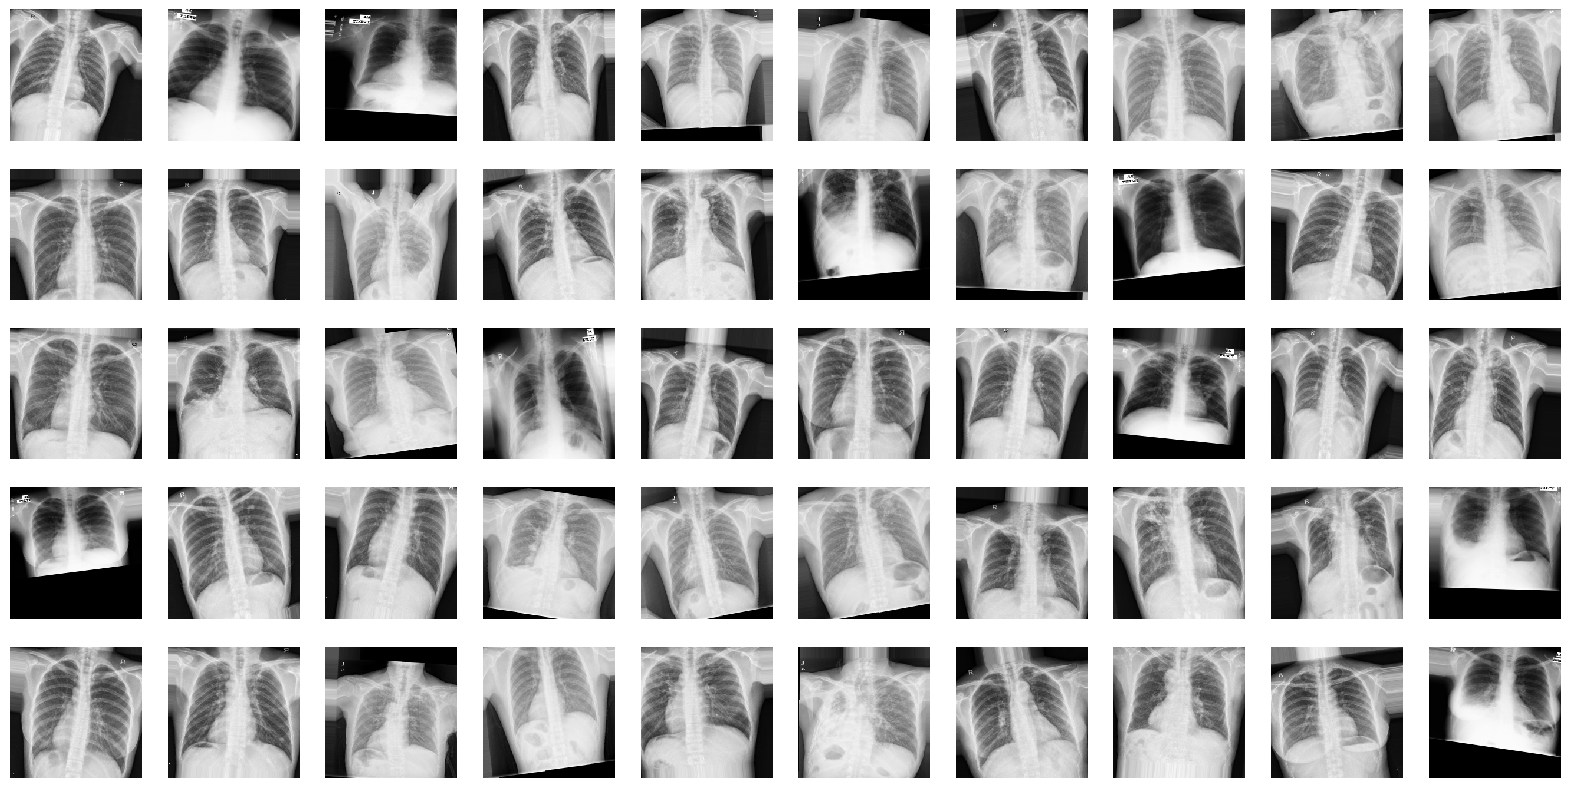

In [52]:
plots(imgs, titles=None) # titles=labels will display the image labels

In [53]:
train_path = 'base_dir/train_dir'
valid_path = 'base_dir/val_dir'

num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = 10
val_batch_size = 10


train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)

In [54]:
datagen = ImageDataGenerator(rescale=1.0/255)

train_gen = datagen.flow_from_directory(train_path,
                                        target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
                                        batch_size=train_batch_size,
                                        class_mode='categorical')

val_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
                                        batch_size=val_batch_size,
                                        class_mode='categorical')

# Note: shuffle=False causes the test dataset to not be shuffled
test_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
                                        batch_size=val_batch_size,
                                        class_mode='categorical',
                                        shuffle=False)

Found 3020 images belonging to 2 classes.
Found 120 images belonging to 2 classes.
Found 120 images belonging to 2 classes.


In [62]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, GlobalAveragePooling2D, BatchNormalization, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import DenseNet169

def build_densenet():
    #IMAGE_HEIGHT = 224  # Update this according to your image size
    #IMAGE_WIDTH = 224   # Update this according to your image size

    densenet = DenseNet169(weights='imagenet', include_top=False)

    input = Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
    x = Conv2D(3, (3, 3), padding='same')(input)

    x = densenet(x)

    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.6)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # multi output
    output = Dense(2, activation='sigmoid', name='root')(x)


    # model
    model = Model(input, output)
    model.compile(Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()

    return model

model = build_densenet()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 3)       84        
                                                                 
 densenet169 (Functional)    (None, None, None, 1664   12642880  
                             )                                   
                                                                 
 global_average_pooling2d (  (None, 1664)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 batch_normalization (Batch  (None, 1664)              6656      
 Normalization)                                                  
                                                             

In [66]:
filepath = "model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1,
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=2,
                                   verbose=1, mode='max', min_lr=0.000001)


callbacks_list = [checkpoint, reduce_lr]

history = model.fit_generator(train_gen, steps_per_epoch=train_steps,
                            validation_data=val_gen,
                            validation_steps=val_steps,
                            epochs=15, verbose=1,
                           callbacks=callbacks_list)

Epoch 1/15


<ipython-input-66-8cffd485c4a0>:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen, steps_per_epoch=train_steps,


68/68 [==============================] - ETA: 0s - loss: 0.3352 - accuracy: 0.8574

68/68 [==============================] - 12s 182ms/step - loss: 0.3352 - accuracy: 0.8574 - val_loss: 1.7777 - val_accuracy: 0.6083 - lr: 0.0010
Epoch 2/15
68/68 [==============================] - ETA: 0s - loss: 0.3326 - accuracy: 0.8559

68/68 [==============================] - 12s 183ms/step - loss: 0.3326 - accuracy: 0.8559 - val_loss: 0.7556 - val_accuracy: 0.6333 - lr: 0.0010
Epoch 3/15
68/68 [==============================] - ETA: 0s - loss: 0.3675 - accuracy: 0.8456

68/68 [==============================] - 12s 179ms/step - loss: 0.3675 - accuracy: 0.8456 - val_loss: 0.5831 - val_accuracy: 0.7417 - lr: 0.0010
Epoch 4/15
68/68 [==============================] - ETA: 0s - loss: 0.3043 - accuracy: 0.8706

68/68 [==============================] - 12s 181ms/step - loss: 0.3043 - accuracy: 0.8706 - val_loss: 1.2118 - val_accuracy: 0.5083 - lr: 0.0010
Epoch 5/15
68/68 [==============================] - ETA: 0s - loss: 0.3280 - accuracy: 0.8721

68/68 [==============================] - 12s 182ms/step - loss: 0.3280 - accuracy: 0.8721 - val_loss: 0.8991 - val_accuracy: 0.6833 - lr: 0.0010
Epoch 6/15
68/68 [==============================] - ETA: 0s - loss: 0.3647 - accuracy: 0.8544

68/68 [==============================] - 12s 182ms/step - loss: 0.3647 - accuracy: 0.8544 - val_loss: 0.6809 - val_accuracy: 0.7250 - lr: 0.0010
Epoch 7/15
68/68 [==============================] - ETA: 0s - loss: 0.2629 - accuracy: 0.8956

68/68 [==============================] - 12s 176ms/step - loss: 0.2629 - accuracy: 0.8956 - val_loss: 0.7225 - val_accuracy: 0.7750 - lr: 0.0010
Epoch 8/15
68/68 [==============================] - ETA: 0s - loss: 0.3144 - accuracy: 0.8603

68/68 [==============================] - 13s 184ms/step - loss: 0.3144 - accuracy: 0.8603 - val_loss: 0.9947 - val_accuracy: 0.5250 - lr: 0.0010
Epoch 9/15
68/68 [==============================] - ETA: 0s - loss: 0.3302 - accuracy: 0.8750

68/68 [==============================] - 12s 183ms/step - loss: 0.3302 - accuracy: 0.8750 - val_loss: 0.5896 - val_accuracy: 0.7250 - lr: 0.0010
Epoch 10/15
68/68 [==============================] - ETA: 0s - loss: 0.2623 - accuracy: 0.9074

68/68 [==============================] - 12s 182ms/step - loss: 0.2623 - accuracy: 0.9074 - val_loss: 0.8251 - val_accuracy: 0.7250 - lr: 0.0010
Epoch 11/15
68/68 [==============================] - ETA: 0s - loss: 0.2914 - accuracy: 0.8735

68/68 [==============================] - 12s 180ms/step - loss: 0.2914 - accuracy: 0.8735 - val_loss: 0.8945 - val_accuracy: 0.6000 - lr: 0.0010
Epoch 12/15
68/68 [==============================] - ETA: 0s - loss: 0.2795 - accuracy: 0.8838

68/68 [==============================] - 12s 181ms/step - loss: 0.2795 - accuracy: 0.8838 - val_loss: 0.6560 - val_accuracy: 0.6000 - lr: 0.0010
Epoch 13/15
68/68 [==============================] - ETA: 0s - loss: 0.2663 - accuracy: 0.9000

68/68 [==============================] - 12s 183ms/step - loss: 0.2663 - accuracy: 0.9000 - val_loss: 0.7438 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 14/15
68/68 [==============================] - ETA: 0s - loss: 0.3022 - accuracy: 0.8838

68/68 [==============================] - 12s 181ms/step - loss: 0.3022 - accuracy: 0.8838 - val_loss: 0.6315 - val_accuracy: 0.7583 - lr: 0.0010
Epoch 15/15
68/68 [==============================] - ETA: 0s - loss: 0.2293 - accuracy: 0.9118

68/68 [==============================] - 13s 189ms/step - loss: 0.2293 - accuracy: 0.9118 - val_loss: 0.8912 - val_accuracy: 0.6750 - lr: 0.0010


In [67]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential

def build_alexnet():
    model = Sequential()

    # Convolutional layers
    model.add(Conv2D(96, (11,11), strides=(4,4), activation='relu', padding='valid', input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid'))
    model.add(Conv2D(256, (5,5), strides=(1,1), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid'))
    model.add(Conv2D(384, (3,3), strides=(1,1), activation='relu', padding='same'))
    model.add(Conv2D(384, (3,3), strides=(1,1), activation='relu', padding='same'))
    model.add(Conv2D(256, (3,3), strides=(1,1), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid'))

    # Flatten the convolution output
    model.add(Flatten())

    # Fully connected layers
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))

    # Output layer
    model.add(Dense(2, activation='sigmoid', name='root'))

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    model.summary()

    return model

model = build_alexnet()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 54, 54, 96)        34944     
                                                                 
 max_pooling2d (MaxPooling2  (None, 26, 26, 96)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 26, 26, 256)       614656    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 12, 12, 256)       0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 12, 12, 384)       885120    
                                                                 
 conv2d_4 (Conv2D)           (None, 12, 12, 384)       1

In [68]:
filepath = "model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1,
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=2,
                                   verbose=1, mode='max', min_lr=0.000001)


callbacks_list = [checkpoint, reduce_lr]

history = model.fit_generator(train_gen, steps_per_epoch=train_steps,
                            validation_data=val_gen,
                            validation_steps=val_steps,
                            epochs=15, verbose=1,
                           callbacks=callbacks_list)

<ipython-input-68-8cffd485c4a0>:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen, steps_per_epoch=train_steps,


Epoch 1/15
67/68 [============================>.] - ETA: 0s - loss: 0.7321 - accuracy: 0.5090

68/68 [==============================] - 11s 38ms/step - loss: 0.7319 - accuracy: 0.5059 - val_loss: 0.6954 - val_accuracy: 0.4917 - lr: 0.0010
Epoch 2/15
67/68 [============================>.] - ETA: 0s - loss: 0.6942 - accuracy: 0.4507

68/68 [==============================] - 2s 36ms/step - loss: 0.6942 - accuracy: 0.4456 - val_loss: 0.6932 - val_accuracy: 0.4917 - lr: 0.0010
Epoch 3/15
67/68 [============================>.] - ETA: 0s - loss: 0.6937 - accuracy: 0.4925

68/68 [==============================] - 2s 36ms/step - loss: 0.6938 - accuracy: 0.4897 - val_loss: 0.6930 - val_accuracy: 0.5083 - lr: 0.0010
Epoch 4/15
68/68 [==============================] - ETA: 0s - loss: 0.6942 - accuracy: 0.5029

68/68 [==============================] - 3s 48ms/step - loss: 0.6942 - accuracy: 0.5029 - val_loss: 0.6931 - val_accuracy: 0.5083 - lr: 0.0010
Epoch 5/15
67/68 [============================>.] - ETA: 0s - loss: 0.6937 - accuracy: 0.4940

68/68 [==============================] - 3s 36ms/step - loss: 0.6936 - accuracy: 0.4985 - val_loss: 0.6933 - val_accuracy: 0.4917 - lr: 0.0010
Epoch 6/15
67/68 [============================>.] - ETA: 0s - loss: 0.6944 - accuracy: 0.4388

68/68 [==============================] - 2s 36ms/step - loss: 0.6944 - accuracy: 0.4368 - val_loss: 0.6931 - val_accuracy: 0.5083 - lr: 0.0010
Epoch 7/15
67/68 [============================>.] - ETA: 0s - loss: 0.6944 - accuracy: 0.4731

68/68 [==============================] - 2s 35ms/step - loss: 0.6942 - accuracy: 0.4765 - val_loss: 0.6932 - val_accuracy: 0.5083 - lr: 0.0010
Epoch 8/15
68/68 [==============================] - ETA: 0s - loss: 0.6921 - accuracy: 0.5294

68/68 [==============================] - 3s 44ms/step - loss: 0.6921 - accuracy: 0.5294 - val_loss: 0.6940 - val_accuracy: 0.5083 - lr: 0.0010
Epoch 9/15
68/68 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.5162

68/68 [==============================] - 3s 47ms/step - loss: 0.6932 - accuracy: 0.5162 - val_loss: 0.6937 - val_accuracy: 0.5083 - lr: 0.0010
Epoch 10/15
67/68 [============================>.] - ETA: 0s - loss: 0.6939 - accuracy: 0.5075

68/68 [==============================] - 2s 36ms/step - loss: 0.6939 - accuracy: 0.5074 - val_loss: 0.6933 - val_accuracy: 0.4917 - lr: 0.0010
Epoch 11/15
67/68 [============================>.] - ETA: 0s - loss: 0.6933 - accuracy: 0.5015

68/68 [==============================] - 2s 36ms/step - loss: 0.6933 - accuracy: 0.5000 - val_loss: 0.6930 - val_accuracy: 0.5083 - lr: 0.0010
Epoch 12/15
67/68 [============================>.] - ETA: 0s - loss: 0.6940 - accuracy: 0.5075

68/68 [==============================] - 3s 37ms/step - loss: 0.6939 - accuracy: 0.5132 - val_loss: 0.6930 - val_accuracy: 0.5083 - lr: 0.0010
Epoch 13/15
68/68 [==============================] - ETA: 0s - loss: 0.6933 - accuracy: 0.5176

68/68 [==============================] - 3s 45ms/step - loss: 0.6933 - accuracy: 0.5176 - val_loss: 0.6932 - val_accuracy: 0.5083 - lr: 0.0010
Epoch 14/15
68/68 [==============================] - ETA: 0s - loss: 0.6945 - accuracy: 0.4765

68/68 [==============================] - 2s 36ms/step - loss: 0.6945 - accuracy: 0.4765 - val_loss: 0.6930 - val_accuracy: 0.5083 - lr: 0.0010
Epoch 15/15
67/68 [============================>.] - ETA: 0s - loss: 0.6931 - accuracy: 0.5119

68/68 [==============================] - 2s 36ms/step - loss: 0.6930 - accuracy: 0.5118 - val_loss: 0.6931 - val_accuracy: 0.5083 - lr: 0.0010


In [69]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, GlobalAveragePooling2D, Dense

def build_InceptionV3():
    inception = InceptionV3(weights='imagenet', include_top=False)

    input_layer = tf.keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
    x = Conv2D(3, (3, 3), padding='same')(input_layer)
    x = inception(x)

    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)  # Additional dense layer
    output = Dense(2, activation='sigmoid', name='root')(x)

    model = Model(inputs=input_layer, outputs=output)

    model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()

    return model

model = build_InceptionV3()


87910968/87910968 [==============================] - 1s 0us/step


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_100 (Conv2D)         (None, 224, 224, 3)       84        
                                                                 
 inception_v3 (Functional)   (None, None, None, 2048   21802784  
                             )                                   
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_3 (Dense)             (None, 256)               524544    
                                                                 
 root (Dense)                (None, 2)                 514 

In [70]:
filepath = "model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1,
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=2,
                                   verbose=1, mode='max', min_lr=0.000001)


callbacks_list = [checkpoint, reduce_lr]

history = model.fit_generator(train_gen, steps_per_epoch=train_steps,
                            validation_data=val_gen,
                            validation_steps=val_steps,
                            epochs=15, verbose=1,
                           callbacks=callbacks_list)

<ipython-input-70-8cffd485c4a0>:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen, steps_per_epoch=train_steps,


Epoch 1/15
68/68 [==============================] - ETA: 0s - loss: 0.6304 - accuracy: 0.6809

68/68 [==============================] - 49s 126ms/step - loss: 0.6304 - accuracy: 0.6809 - val_loss: 1.0717 - val_accuracy: 0.5083 - lr: 0.0010
Epoch 2/15
68/68 [==============================] - ETA: 0s - loss: 0.4911 - accuracy: 0.7632

68/68 [==============================] - 8s 109ms/step - loss: 0.4911 - accuracy: 0.7632 - val_loss: 0.7356 - val_accuracy: 0.5083 - lr: 0.0010
Epoch 3/15
68/68 [==============================] - ETA: 0s - loss: 0.5240 - accuracy: 0.7647

68/68 [==============================] - 7s 107ms/step - loss: 0.5240 - accuracy: 0.7647 - val_loss: 87.5260 - val_accuracy: 0.5083 - lr: 0.0010
Epoch 4/15
68/68 [==============================] - ETA: 0s - loss: 0.4699 - accuracy: 0.7882

68/68 [==============================] - 7s 109ms/step - loss: 0.4699 - accuracy: 0.7882 - val_loss: 0.9134 - val_accuracy: 0.5083 - lr: 0.0010
Epoch 5/15
68/68 [==============================] - ETA: 0s - loss: 0.5594 - accuracy: 0.7382

68/68 [==============================] - 7s 107ms/step - loss: 0.5594 - accuracy: 0.7382 - val_loss: 578.4494 - val_accuracy: 0.5083 - lr: 0.0010
Epoch 6/15
68/68 [==============================] - ETA: 0s - loss: 0.5244 - accuracy: 0.7735

68/68 [==============================] - 7s 103ms/step - loss: 0.5244 - accuracy: 0.7735 - val_loss: 13.7921 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 7/15
68/68 [==============================] - ETA: 0s - loss: 0.4629 - accuracy: 0.8029

68/68 [==============================] - 8s 113ms/step - loss: 0.4629 - accuracy: 0.8029 - val_loss: 0.8483 - val_accuracy: 0.5333 - lr: 0.0010
Epoch 8/15
68/68 [==============================] - ETA: 0s - loss: 0.4651 - accuracy: 0.7971

68/68 [==============================] - 8s 111ms/step - loss: 0.4651 - accuracy: 0.7971 - val_loss: 0.6658 - val_accuracy: 0.7083 - lr: 0.0010
Epoch 9/15
68/68 [==============================] - ETA: 0s - loss: 0.4371 - accuracy: 0.7985

68/68 [==============================] - 7s 102ms/step - loss: 0.4371 - accuracy: 0.7985 - val_loss: 89.9274 - val_accuracy: 0.5083 - lr: 0.0010
Epoch 10/15
68/68 [==============================] - ETA: 0s - loss: 0.4462 - accuracy: 0.8162

68/68 [==============================] - 7s 109ms/step - loss: 0.4462 - accuracy: 0.8162 - val_loss: 1.0838 - val_accuracy: 0.5667 - lr: 0.0010
Epoch 11/15
68/68 [==============================] - ETA: 0s - loss: 0.3984 - accuracy: 0.8382

68/68 [==============================] - 7s 103ms/step - loss: 0.3984 - accuracy: 0.8382 - val_loss: 4.4939 - val_accuracy: 0.4917 - lr: 0.0010
Epoch 12/15
68/68 [==============================] - ETA: 0s - loss: 0.3422 - accuracy: 0.8662

68/68 [==============================] - 7s 109ms/step - loss: 0.3422 - accuracy: 0.8662 - val_loss: 1.1389 - val_accuracy: 0.5583 - lr: 0.0010
Epoch 13/15
68/68 [==============================] - ETA: 0s - loss: 0.3817 - accuracy: 0.8412

68/68 [==============================] - 7s 101ms/step - loss: 0.3817 - accuracy: 0.8412 - val_loss: 0.8322 - val_accuracy: 0.7250 - lr: 0.0010
Epoch 14/15
68/68 [==============================] - ETA: 0s - loss: 0.3451 - accuracy: 0.8544

68/68 [==============================] - 7s 109ms/step - loss: 0.3451 - accuracy: 0.8544 - val_loss: 0.7740 - val_accuracy: 0.6667 - lr: 0.0010
Epoch 15/15
68/68 [==============================] - ETA: 0s - loss: 0.3410 - accuracy: 0.8603

68/68 [==============================] - 8s 111ms/step - loss: 0.3410 - accuracy: 0.8603 - val_loss: 1.2309 - val_accuracy: 0.5667 - lr: 0.0010


In [71]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, GlobalAveragePooling2D, Dense

def build_ResNet50():
    resnet = ResNet50(weights='imagenet', include_top=False)

    input_layer = tf.keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
    x = Conv2D(3, (3, 3), padding='same')(input_layer)
    x = resnet(x)

    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)  # Additional dense layer
    output = Dense(2, activation='sigmoid', name='root')(x)

    model = Model(inputs=input_layer, outputs=output)

    model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()

    return model

model = build_ResNet50()


94765736/94765736 [==============================] - 1s 0us/step


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_101 (Conv2D)         (None, 224, 224, 3)       84        
                                                                 
 resnet50 (Functional)       (None, None, None, 2048   23587712  
                             )                                   
                                                                 
 global_average_pooling2d_2  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_4 (Dense)             (None, 256)               524544    
                                                                 
 root (Dense)                (None, 2)                 514 

In [72]:
filepath = "model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1,
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=2,
                                   verbose=1, mode='max', min_lr=0.000001)


callbacks_list = [checkpoint, reduce_lr]

history = model.fit_generator(train_gen, steps_per_epoch=train_steps,
                            validation_data=val_gen,
                            validation_steps=val_steps,
                            epochs=15, verbose=1,
                           callbacks=callbacks_list)

Epoch 1/15


<ipython-input-72-8cffd485c4a0>:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen, steps_per_epoch=train_steps,


68/68 [==============================] - ETA: 0s - loss: 0.6783 - accuracy: 0.6926

68/68 [==============================] - 46s 157ms/step - loss: 0.6783 - accuracy: 0.6926 - val_loss: 13.3458 - val_accuracy: 0.4917 - lr: 0.0010
Epoch 2/15
68/68 [==============================] - ETA: 0s - loss: 0.5571 - accuracy: 0.7426

68/68 [==============================] - 10s 144ms/step - loss: 0.5571 - accuracy: 0.7426 - val_loss: 0.7556 - val_accuracy: 0.5083 - lr: 0.0010
Epoch 3/15
68/68 [==============================] - ETA: 0s - loss: 0.4880 - accuracy: 0.7735

68/68 [==============================] - 10s 146ms/step - loss: 0.4880 - accuracy: 0.7735 - val_loss: 0.6947 - val_accuracy: 0.5083 - lr: 0.0010
Epoch 4/15
68/68 [==============================] - ETA: 0s - loss: 0.4528 - accuracy: 0.8029

68/68 [==============================] - 10s 142ms/step - loss: 0.4528 - accuracy: 0.8029 - val_loss: 2.2191 - val_accuracy: 0.5083 - lr: 0.0010
Epoch 5/15
68/68 [==============================] - ETA: 0s - loss: 0.4267 - accuracy: 0.8176

68/68 [==============================] - 10s 145ms/step - loss: 0.4267 - accuracy: 0.8176 - val_loss: 0.7353 - val_accuracy: 0.5083 - lr: 0.0010
Epoch 6/15
68/68 [==============================] - ETA: 0s - loss: 0.3865 - accuracy: 0.8353

68/68 [==============================] - 10s 151ms/step - loss: 0.3865 - accuracy: 0.8353 - val_loss: 1.5531 - val_accuracy: 0.5083 - lr: 0.0010
Epoch 7/15
68/68 [==============================] - ETA: 0s - loss: 0.3992 - accuracy: 0.8221

68/68 [==============================] - 10s 143ms/step - loss: 0.3992 - accuracy: 0.8221 - val_loss: 1.7730 - val_accuracy: 0.5083 - lr: 0.0010
Epoch 8/15
68/68 [==============================] - ETA: 0s - loss: 0.4862 - accuracy: 0.7926

68/68 [==============================] - 10s 140ms/step - loss: 0.4862 - accuracy: 0.7926 - val_loss: 0.8938 - val_accuracy: 0.5083 - lr: 0.0010
Epoch 9/15
68/68 [==============================] - ETA: 0s - loss: 0.4072 - accuracy: 0.8235

68/68 [==============================] - 10s 143ms/step - loss: 0.4072 - accuracy: 0.8235 - val_loss: 0.6908 - val_accuracy: 0.5083 - lr: 0.0010
Epoch 10/15
68/68 [==============================] - ETA: 0s - loss: 0.4128 - accuracy: 0.8250

68/68 [==============================] - 10s 143ms/step - loss: 0.4128 - accuracy: 0.8250 - val_loss: 0.7110 - val_accuracy: 0.4917 - lr: 0.0010
Epoch 11/15
68/68 [==============================] - ETA: 0s - loss: 0.3777 - accuracy: 0.8426

68/68 [==============================] - 10s 144ms/step - loss: 0.3777 - accuracy: 0.8426 - val_loss: 0.6940 - val_accuracy: 0.5083 - lr: 0.0010
Epoch 12/15
68/68 [==============================] - ETA: 0s - loss: 0.3821 - accuracy: 0.8382

68/68 [==============================] - 10s 141ms/step - loss: 0.3821 - accuracy: 0.8382 - val_loss: 0.7887 - val_accuracy: 0.5083 - lr: 0.0010
Epoch 13/15
68/68 [==============================] - ETA: 0s - loss: 0.3604 - accuracy: 0.8382

68/68 [==============================] - 10s 143ms/step - loss: 0.3604 - accuracy: 0.8382 - val_loss: 0.6920 - val_accuracy: 0.5083 - lr: 0.0010
Epoch 14/15
68/68 [==============================] - ETA: 0s - loss: 0.3375 - accuracy: 0.8588

68/68 [==============================] - 10s 143ms/step - loss: 0.3375 - accuracy: 0.8588 - val_loss: 0.7028 - val_accuracy: 0.3417 - lr: 0.0010
Epoch 15/15
68/68 [==============================] - ETA: 0s - loss: 0.3842 - accuracy: 0.8456

68/68 [==============================] - 10s 145ms/step - loss: 0.3842 - accuracy: 0.8456 - val_loss: 0.7078 - val_accuracy: 0.5083 - lr: 0.0010


In [73]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, GlobalAveragePooling2D, Dense

def build_VGG16():
    vgg16 = VGG16(weights='imagenet', include_top=False)

    input_layer = tf.keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
    x = Conv2D(3, (3, 3), padding='same')(input_layer)
    x = vgg16(x)

    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)  # Additional dense layer
    output = Dense(2, activation='sigmoid', name='root')(x)

    model = Model(inputs=input_layer, outputs=output)

    model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()

    return model

model = build_VGG16()


58889256/58889256 [==============================] - 0s 0us/step


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_102 (Conv2D)         (None, 224, 224, 3)       84        
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 global_average_pooling2d_3  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_5 (Dense)             (None, 256)               131328    
                                                                 
 root (Dense)                (None, 2)                 514       
                                                           

In [74]:
filepath = "model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1,
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=2,
                                   verbose=1, mode='max', min_lr=0.000001)


callbacks_list = [checkpoint, reduce_lr]

history = model.fit_generator(train_gen, steps_per_epoch=train_steps,
                            validation_data=val_gen,
                            validation_steps=val_steps,
                            epochs=15, verbose=1,
                           callbacks=callbacks_list)

Epoch 1/15


<ipython-input-74-8cffd485c4a0>:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen, steps_per_epoch=train_steps,


68/68 [==============================] - ETA: 0s - loss: 0.7470 - accuracy: 0.4868

68/68 [==============================] - 26s 178ms/step - loss: 0.7470 - accuracy: 0.4868 - val_loss: 0.6914 - val_accuracy: 0.6417 - lr: 0.0010
Epoch 2/15
68/68 [==============================] - ETA: 0s - loss: 0.6967 - accuracy: 0.5118

68/68 [==============================] - 12s 173ms/step - loss: 0.6967 - accuracy: 0.5118 - val_loss: 0.7109 - val_accuracy: 0.4917 - lr: 0.0010
Epoch 3/15
68/68 [==============================] - ETA: 0s - loss: 0.7092 - accuracy: 0.5015

68/68 [==============================] - 12s 174ms/step - loss: 0.7092 - accuracy: 0.5015 - val_loss: 0.6935 - val_accuracy: 0.5083 - lr: 0.0010
Epoch 4/15
68/68 [==============================] - ETA: 0s - loss: 0.6936 - accuracy: 0.4926

68/68 [==============================] - 11s 168ms/step - loss: 0.6936 - accuracy: 0.4926 - val_loss: 0.6930 - val_accuracy: 0.5083 - lr: 0.0010
Epoch 5/15
68/68 [==============================] - ETA: 0s - loss: 0.6906 - accuracy: 0.5529

68/68 [==============================] - 11s 167ms/step - loss: 0.6906 - accuracy: 0.5529 - val_loss: 0.6933 - val_accuracy: 0.5083 - lr: 0.0010
Epoch 6/15
68/68 [==============================] - ETA: 0s - loss: 0.6937 - accuracy: 0.5059

68/68 [==============================] - 11s 166ms/step - loss: 0.6937 - accuracy: 0.5059 - val_loss: 0.6932 - val_accuracy: 0.5083 - lr: 0.0010
Epoch 7/15
68/68 [==============================] - ETA: 0s - loss: 0.6925 - accuracy: 0.5206

68/68 [==============================] - 11s 165ms/step - loss: 0.6925 - accuracy: 0.5206 - val_loss: 0.6932 - val_accuracy: 0.5083 - lr: 0.0010
Epoch 8/15
68/68 [==============================] - ETA: 0s - loss: 0.6942 - accuracy: 0.4956

68/68 [==============================] - 11s 164ms/step - loss: 0.6942 - accuracy: 0.4956 - val_loss: 0.6931 - val_accuracy: 0.5083 - lr: 0.0010
Epoch 9/15
68/68 [==============================] - ETA: 0s - loss: 0.6930 - accuracy: 0.5147

68/68 [==============================] - 11s 167ms/step - loss: 0.6930 - accuracy: 0.5147 - val_loss: 0.6930 - val_accuracy: 0.5083 - lr: 0.0010
Epoch 10/15
68/68 [==============================] - ETA: 0s - loss: 0.6928 - accuracy: 0.5162

68/68 [==============================] - 12s 179ms/step - loss: 0.6928 - accuracy: 0.5162 - val_loss: 0.6931 - val_accuracy: 0.5083 - lr: 0.0010
Epoch 11/15
68/68 [==============================] - ETA: 0s - loss: 0.6945 - accuracy: 0.4706

68/68 [==============================] - 12s 174ms/step - loss: 0.6945 - accuracy: 0.4706 - val_loss: 0.6930 - val_accuracy: 0.5083 - lr: 0.0010
Epoch 12/15
68/68 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.5044

68/68 [==============================] - 11s 166ms/step - loss: 0.6932 - accuracy: 0.5044 - val_loss: 0.6931 - val_accuracy: 0.5083 - lr: 0.0010
Epoch 13/15
68/68 [==============================] - ETA: 0s - loss: 0.6931 - accuracy: 0.5059

68/68 [==============================] - 11s 168ms/step - loss: 0.6931 - accuracy: 0.5059 - val_loss: 0.6931 - val_accuracy: 0.5083 - lr: 0.0010
Epoch 14/15
68/68 [==============================] - ETA: 0s - loss: 0.6925 - accuracy: 0.5324

68/68 [==============================] - 11s 168ms/step - loss: 0.6925 - accuracy: 0.5324 - val_loss: 0.6930 - val_accuracy: 0.5083 - lr: 0.0010
Epoch 15/15
68/68 [==============================] - ETA: 0s - loss: 0.6937 - accuracy: 0.4897

68/68 [==============================] - 11s 167ms/step - loss: 0.6937 - accuracy: 0.4897 - val_loss: 0.6930 - val_accuracy: 0.5083 - lr: 0.0010


In [75]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, GlobalAveragePooling2D, Dense

def build_VGG19():
    vgg19 = VGG19(weights='imagenet', include_top=False)

    input_layer = tf.keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
    x = Conv2D(3, (3, 3), padding='same')(input_layer)
    x = vgg19(x)

    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)  # Additional dense layer
    output = Dense(2, activation='sigmoid', name='root')(x)

    model = Model(inputs=input_layer, outputs=output)

    model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()

    return model

model = build_VGG19()


80134624/80134624 [==============================] - 0s 0us/step


Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_103 (Conv2D)         (None, 224, 224, 3)       84        
                                                                 
 vgg19 (Functional)          (None, None, None, 512)   20024384  
                                                                 
 global_average_pooling2d_4  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_6 (Dense)             (None, 256)               131328    
                                                                 
 root (Dense)                (None, 2)                 514       
                                                           

In [76]:
filepath = "model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1,
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=2,
                                   verbose=1, mode='max', min_lr=0.000001)


callbacks_list = [checkpoint, reduce_lr]

history = model.fit_generator(train_gen, steps_per_epoch=train_steps,
                            validation_data=val_gen,
                            validation_steps=val_steps,
                            epochs=15, verbose=1,
                           callbacks=callbacks_list)

Epoch 1/15


<ipython-input-76-8cffd485c4a0>:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen, steps_per_epoch=train_steps,


68/68 [==============================] - ETA: 0s - loss: 3.0689 - accuracy: 0.5029

68/68 [==============================] - 21s 211ms/step - loss: 3.0689 - accuracy: 0.5029 - val_loss: 0.6966 - val_accuracy: 0.4917 - lr: 0.0010
Epoch 2/15
68/68 [==============================] - ETA: 0s - loss: 0.6980 - accuracy: 0.4853

68/68 [==============================] - 14s 209ms/step - loss: 0.6980 - accuracy: 0.4853 - val_loss: 0.6940 - val_accuracy: 0.5083 - lr: 0.0010
Epoch 3/15
68/68 [==============================] - ETA: 0s - loss: 0.6926 - accuracy: 0.5485

68/68 [==============================] - 14s 209ms/step - loss: 0.6926 - accuracy: 0.5485 - val_loss: 0.6976 - val_accuracy: 0.5083 - lr: 0.0010
Epoch 4/15
68/68 [==============================] - ETA: 0s - loss: 0.6971 - accuracy: 0.4588

68/68 [==============================] - 15s 216ms/step - loss: 0.6971 - accuracy: 0.4588 - val_loss: 0.6941 - val_accuracy: 0.4917 - lr: 0.0010
Epoch 5/15
68/68 [==============================] - ETA: 0s - loss: 0.6951 - accuracy: 0.5176

68/68 [==============================] - 14s 207ms/step - loss: 0.6951 - accuracy: 0.5176 - val_loss: 0.6937 - val_accuracy: 0.5083 - lr: 0.0010
Epoch 6/15
68/68 [==============================] - ETA: 0s - loss: 0.6943 - accuracy: 0.4897

68/68 [==============================] - 14s 206ms/step - loss: 0.6943 - accuracy: 0.4897 - val_loss: 0.6932 - val_accuracy: 0.5083 - lr: 0.0010
Epoch 7/15
68/68 [==============================] - ETA: 0s - loss: 0.6933 - accuracy: 0.4882

68/68 [==============================] - 14s 203ms/step - loss: 0.6933 - accuracy: 0.4882 - val_loss: 0.6930 - val_accuracy: 0.5083 - lr: 0.0010
Epoch 8/15
68/68 [==============================] - ETA: 0s - loss: 0.6930 - accuracy: 0.5147

68/68 [==============================] - 14s 201ms/step - loss: 0.6930 - accuracy: 0.5147 - val_loss: 0.6930 - val_accuracy: 0.5083 - lr: 0.0010
Epoch 9/15
68/68 [==============================] - ETA: 0s - loss: 0.6929 - accuracy: 0.5162

68/68 [==============================] - 14s 201ms/step - loss: 0.6929 - accuracy: 0.5162 - val_loss: 0.6930 - val_accuracy: 0.5083 - lr: 0.0010
Epoch 10/15
68/68 [==============================] - ETA: 0s - loss: 0.6939 - accuracy: 0.4809

68/68 [==============================] - 14s 202ms/step - loss: 0.6939 - accuracy: 0.4809 - val_loss: 0.6931 - val_accuracy: 0.5083 - lr: 0.0010
Epoch 11/15
68/68 [==============================] - ETA: 0s - loss: 0.6930 - accuracy: 0.5191

68/68 [==============================] - 14s 202ms/step - loss: 0.6930 - accuracy: 0.5191 - val_loss: 0.6930 - val_accuracy: 0.5083 - lr: 0.0010
Epoch 12/15
68/68 [==============================] - ETA: 0s - loss: 0.6929 - accuracy: 0.5191

68/68 [==============================] - 14s 201ms/step - loss: 0.6929 - accuracy: 0.5191 - val_loss: 0.6930 - val_accuracy: 0.5083 - lr: 0.0010
Epoch 13/15
68/68 [==============================] - ETA: 0s - loss: 0.6918 - accuracy: 0.5382

68/68 [==============================] - 14s 200ms/step - loss: 0.6918 - accuracy: 0.5382 - val_loss: 0.6932 - val_accuracy: 0.5083 - lr: 0.0010
Epoch 14/15
68/68 [==============================] - ETA: 0s - loss: 0.6947 - accuracy: 0.4765

68/68 [==============================] - 14s 203ms/step - loss: 0.6947 - accuracy: 0.4765 - val_loss: 0.6930 - val_accuracy: 0.5083 - lr: 0.0010
Epoch 15/15
68/68 [==============================] - ETA: 0s - loss: 0.6933 - accuracy: 0.5029

68/68 [==============================] - 14s 204ms/step - loss: 0.6933 - accuracy: 0.5029 - val_loss: 0.6930 - val_accuracy: 0.5083 - lr: 0.0010


In [79]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, GlobalAveragePooling2D, Dense

def build_GoogLeNet():
    inception = InceptionV3(weights='imagenet', include_top=False)

    input_layer = tf.keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
    x = Conv2D(3, (3, 3), padding='same')(input_layer)
    x = inception(x)

    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)  # Additional dense layer
    output = Dense(2, activation='sigmoid', name='root')(x)

    model = Model(inputs=input_layer, outputs=output)

    model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()

    return model

model = build_GoogLeNet()


Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_293 (Conv2D)         (None, 224, 224, 3)       84        
                                                                 
 inception_v3 (Functional)   (None, None, None, 2048   21802784  
                             )                                   
                                                                 
 global_average_pooling2d_6  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_8 (Dense)             (None, 256)               524544    
                                                                 
 root (Dense)                (None, 2)                 514 

In [80]:
filepath = "model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1,
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=2,
                                   verbose=1, mode='max', min_lr=0.000001)


callbacks_list = [checkpoint, reduce_lr]

history = model.fit_generator(train_gen, steps_per_epoch=train_steps,
                            validation_data=val_gen,
                            validation_steps=val_steps,
                            epochs=15, verbose=1,
                           callbacks=callbacks_list)

Epoch 1/15


<ipython-input-80-8cffd485c4a0>:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen, steps_per_epoch=train_steps,


68/68 [==============================] - ETA: 0s - loss: 0.6206 - accuracy: 0.7118

68/68 [==============================] - 39s 127ms/step - loss: 0.6206 - accuracy: 0.7118 - val_loss: 32.6642 - val_accuracy: 0.5083 - lr: 0.0010
Epoch 2/15
68/68 [==============================] - ETA: 0s - loss: 0.5065 - accuracy: 0.7676

68/68 [==============================] - 7s 109ms/step - loss: 0.5065 - accuracy: 0.7676 - val_loss: 102.5882 - val_accuracy: 0.5083 - lr: 0.0010
Epoch 3/15
68/68 [==============================] - ETA: 0s - loss: 0.5020 - accuracy: 0.7676

68/68 [==============================] - 7s 103ms/step - loss: 0.5020 - accuracy: 0.7676 - val_loss: 1.7564 - val_accuracy: 0.6750 - lr: 0.0010
Epoch 4/15
68/68 [==============================] - ETA: 0s - loss: 0.4891 - accuracy: 0.7721

68/68 [==============================] - 7s 110ms/step - loss: 0.4891 - accuracy: 0.7721 - val_loss: 0.6944 - val_accuracy: 0.6750 - lr: 0.0010
Epoch 5/15
68/68 [==============================] - ETA: 0s - loss: 0.3966 - accuracy: 0.8132

68/68 [==============================] - 7s 104ms/step - loss: 0.3966 - accuracy: 0.8132 - val_loss: 1.7137 - val_accuracy: 0.6917 - lr: 0.0010
Epoch 6/15
68/68 [==============================] - ETA: 0s - loss: 0.4369 - accuracy: 0.8044

68/68 [==============================] - 7s 110ms/step - loss: 0.4369 - accuracy: 0.8044 - val_loss: 1.2733 - val_accuracy: 0.5083 - lr: 0.0010
Epoch 7/15
68/68 [==============================] - ETA: 0s - loss: 0.4354 - accuracy: 0.8118

68/68 [==============================] - 7s 104ms/step - loss: 0.4354 - accuracy: 0.8118 - val_loss: 2.8278 - val_accuracy: 0.7250 - lr: 0.0010
Epoch 8/15
68/68 [==============================] - ETA: 0s - loss: 0.3770 - accuracy: 0.8515

68/68 [==============================] - 7s 102ms/step - loss: 0.3770 - accuracy: 0.8515 - val_loss: 4.1403 - val_accuracy: 0.5750 - lr: 0.0010
Epoch 9/15
68/68 [==============================] - ETA: 0s - loss: 0.3974 - accuracy: 0.8353

68/68 [==============================] - 7s 108ms/step - loss: 0.3974 - accuracy: 0.8353 - val_loss: 0.9999 - val_accuracy: 0.7333 - lr: 0.0010
Epoch 10/15
68/68 [==============================] - ETA: 0s - loss: 0.3420 - accuracy: 0.8574

68/68 [==============================] - 7s 105ms/step - loss: 0.3420 - accuracy: 0.8574 - val_loss: 11.7402 - val_accuracy: 0.6667 - lr: 0.0010
Epoch 11/15
68/68 [==============================] - ETA: 0s - loss: 0.3354 - accuracy: 0.8485

68/68 [==============================] - 7s 102ms/step - loss: 0.3354 - accuracy: 0.8485 - val_loss: 1.1704 - val_accuracy: 0.5750 - lr: 0.0010
Epoch 12/15
68/68 [==============================] - ETA: 0s - loss: 0.3289 - accuracy: 0.8721

68/68 [==============================] - 7s 109ms/step - loss: 0.3289 - accuracy: 0.8721 - val_loss: 1.2021 - val_accuracy: 0.6417 - lr: 0.0010
Epoch 13/15
68/68 [==============================] - ETA: 0s - loss: 0.3064 - accuracy: 0.8662

68/68 [==============================] - 7s 102ms/step - loss: 0.3064 - accuracy: 0.8662 - val_loss: 2.0215 - val_accuracy: 0.5750 - lr: 0.0010
Epoch 14/15
68/68 [==============================] - ETA: 0s - loss: 0.3174 - accuracy: 0.8794

68/68 [==============================] - 7s 109ms/step - loss: 0.3174 - accuracy: 0.8794 - val_loss: 0.5204 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 15/15
68/68 [==============================] - ETA: 0s - loss: 0.2682 - accuracy: 0.8868

68/68 [==============================] - 7s 103ms/step - loss: 0.2682 - accuracy: 0.8868 - val_loss: 0.5460 - val_accuracy: 0.6917 - lr: 0.0010


In [81]:
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, GlobalAveragePooling2D, Dense

def build_InceptionResNetV2():
    inception_resnet = InceptionResNetV2(weights='imagenet', include_top=False)

    input_layer = tf.keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
    x = Conv2D(3, (3, 3), padding='same')(input_layer)
    x = inception_resnet(x)

    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)  # Additional dense layer
    output = Dense(2, activation='sigmoid', name='root')(x)

    model = Model(inputs=input_layer, outputs=output)

    model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()

    return model

model = build_InceptionResNetV2()


219055592/219055592 [==============================] - 2s 0us/step


Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_497 (Conv2D)         (None, 224, 224, 3)       84        
                                                                 
 inception_resnet_v2 (Funct  (None, None, None, 1536   54336736  
 ional)                      )                                   
                                                                 
 global_average_pooling2d_7  (None, 1536)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_9 (Dense)             (None, 256)               393472    
                                                                 
 root (Dense)                (None, 2)                 514 

In [82]:
filepath = "model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1,
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=2,
                                   verbose=1, mode='max', min_lr=0.000001)


callbacks_list = [checkpoint, reduce_lr]

history = model.fit_generator(train_gen, steps_per_epoch=train_steps,
                            validation_data=val_gen,
                            validation_steps=val_steps,
                            epochs=15, verbose=1,
                           callbacks=callbacks_list)

Epoch 1/15


<ipython-input-82-8cffd485c4a0>:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen, steps_per_epoch=train_steps,


68/68 [==============================] - ETA: 0s - loss: 0.5752 - accuracy: 0.7235

68/68 [==============================] - 108s 298ms/step - loss: 0.5752 - accuracy: 0.7235 - val_loss: 3.3523 - val_accuracy: 0.5167 - lr: 0.0010
Epoch 2/15
68/68 [==============================] - ETA: 0s - loss: 0.4499 - accuracy: 0.8000

68/68 [==============================] - 16s 230ms/step - loss: 0.4499 - accuracy: 0.8000 - val_loss: 2.9619 - val_accuracy: 0.5083 - lr: 0.0010
Epoch 3/15
68/68 [==============================] - ETA: 0s - loss: 0.3405 - accuracy: 0.8618

68/68 [==============================] - 16s 236ms/step - loss: 0.3405 - accuracy: 0.8618 - val_loss: 2.5605 - val_accuracy: 0.5167 - lr: 0.0010
Epoch 4/15
68/68 [==============================] - ETA: 0s - loss: 0.3897 - accuracy: 0.8500

68/68 [==============================] - 16s 236ms/step - loss: 0.3897 - accuracy: 0.8500 - val_loss: 13.3093 - val_accuracy: 0.5083 - lr: 0.0010
Epoch 5/15
68/68 [==============================] - ETA: 0s - loss: 0.3560 - accuracy: 0.8544

68/68 [==============================] - 16s 235ms/step - loss: 0.3560 - accuracy: 0.8544 - val_loss: 0.6330 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 6/15
68/68 [==============================] - ETA: 0s - loss: 0.3150 - accuracy: 0.8735

68/68 [==============================] - 16s 233ms/step - loss: 0.3150 - accuracy: 0.8735 - val_loss: 0.6206 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 7/15
68/68 [==============================] - ETA: 0s - loss: 0.2969 - accuracy: 0.8676

68/68 [==============================] - 16s 241ms/step - loss: 0.2969 - accuracy: 0.8676 - val_loss: 0.4635 - val_accuracy: 0.8083 - lr: 0.0010
Epoch 8/15
68/68 [==============================] - ETA: 0s - loss: 0.3255 - accuracy: 0.8676

68/68 [==============================] - 16s 234ms/step - loss: 0.3255 - accuracy: 0.8676 - val_loss: 0.4769 - val_accuracy: 0.7333 - lr: 0.0010
Epoch 9/15
68/68 [==============================] - ETA: 0s - loss: 0.2408 - accuracy: 0.9162

68/68 [==============================] - 16s 236ms/step - loss: 0.2408 - accuracy: 0.9162 - val_loss: 0.8100 - val_accuracy: 0.6833 - lr: 0.0010
Epoch 10/15
68/68 [==============================] - ETA: 0s - loss: 0.2776 - accuracy: 0.8824

68/68 [==============================] - 16s 243ms/step - loss: 0.2776 - accuracy: 0.8824 - val_loss: 0.4929 - val_accuracy: 0.8500 - lr: 0.0010
Epoch 11/15
68/68 [==============================] - ETA: 0s - loss: 0.1788 - accuracy: 0.9338

68/68 [==============================] - 16s 234ms/step - loss: 0.1788 - accuracy: 0.9338 - val_loss: 1.3520 - val_accuracy: 0.7667 - lr: 0.0010
Epoch 12/15
68/68 [==============================] - ETA: 0s - loss: 0.2603 - accuracy: 0.9029

68/68 [==============================] - 16s 234ms/step - loss: 0.2603 - accuracy: 0.9029 - val_loss: 2.1351 - val_accuracy: 0.5750 - lr: 0.0010
Epoch 13/15
68/68 [==============================] - ETA: 0s - loss: 0.2450 - accuracy: 0.8956

68/68 [==============================] - 16s 233ms/step - loss: 0.2450 - accuracy: 0.8956 - val_loss: 0.6842 - val_accuracy: 0.8083 - lr: 0.0010
Epoch 14/15
68/68 [==============================] - ETA: 0s - loss: 0.1987 - accuracy: 0.9191

68/68 [==============================] - 16s 235ms/step - loss: 0.1987 - accuracy: 0.9191 - val_loss: 0.4486 - val_accuracy: 0.8000 - lr: 0.0010
Epoch 15/15
68/68 [==============================] - ETA: 0s - loss: 0.1927 - accuracy: 0.9279

68/68 [==============================] - 16s 234ms/step - loss: 0.1927 - accuracy: 0.9279 - val_loss: 1.5844 - val_accuracy: 0.7250 - lr: 0.0010


In [94]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, concatenate, GlobalAveragePooling2D, Dense, Activation
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

def fire_module(x, squeeze_filters, expand_filters):
    squeeze = Conv2D(squeeze_filters, (1, 1), activation='relu', padding='same')(x)
    expand_1x1 = Conv2D(expand_filters, (1, 1), activation='relu', padding='same')(squeeze)
    expand_3x3 = Conv2D(expand_filters, (3, 3), activation='relu', padding='same')(squeeze)
    return concatenate([expand_1x1, expand_3x3], axis=-1)

def build_SqueezeNet(input_shape=(224, 224, 3), num_classes=2):
    input_layer = Input(shape=input_shape)

    x = Conv2D(64, (3, 3), activation='relu', padding='valid', strides=(2, 2))(input_layer)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)

    x = fire_module(x, squeeze_filters=16, expand_filters=64)
    x = fire_module(x, squeeze_filters=16, expand_filters=64)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)

    x = fire_module(x, squeeze_filters=32, expand_filters=128)
    x = fire_module(x, squeeze_filters=32, expand_filters=128)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)

    x = fire_module(x, squeeze_filters=48, expand_filters=192)
    x = fire_module(x, squeeze_filters=48, expand_filters=192)
    x = fire_module(x, squeeze_filters=64, expand_filters=256)
    x = fire_module(x, squeeze_filters=64, expand_filters=256)

    x = Dropout(0.5)(x)
    x = Conv2D(num_classes, (1, 1), activation='relu', padding='valid')(x)
    x = GlobalAveragePooling2D()(x)
    output = Activation('softmax')(x)

    model = Model(inputs=input_layer, outputs=output)
    return model

# Build the model
model = build_SqueezeNet()

# Compile the model with 'learning_rate' instead of 'lr'
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
filepath = "model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2, verbose=1, mode='max', min_lr=0.000001)
callbacks_list = [checkpoint, reduce_lr]

# Train the model using 'fit'
history = model.fit(train_gen, steps_per_epoch=train_steps,
                    validation_data=val_gen, validation_steps=val_steps,
                    epochs=15, verbose=1, callbacks=callbacks_list)


Epoch 1/15
68/68 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.4971
Epoch 1: val_accuracy improved from -inf to 0.50833, saving model to model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


68/68 [==============================] - 16s 59ms/step - loss: 0.6932 - accuracy: 0.4971 - val_loss: 0.6931 - val_accuracy: 0.5083 - lr: 1.0000e-04
Epoch 2/15
67/68 [============================>.] - ETA: 0s - loss: 0.6931 - accuracy: 0.5343
Epoch 2: val_accuracy did not improve from 0.50833
68/68 [==============================] - 2s 35ms/step - loss: 0.6931 - accuracy: 0.5324 - val_loss: 0.6931 - val_accuracy: 0.5083 - lr: 1.0000e-04
Epoch 3/15
67/68 [============================>.] - ETA: 0s - loss: 0.6931 - accuracy: 0.5045
Epoch 3: val_accuracy did not improve from 0.50833

Epoch 3: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
68/68 [==============================] - 2s 36ms/step - loss: 0.6931 - accuracy: 0.5044 - val_loss: 0.6931 - val_accuracy: 0.5083 - lr: 1.0000e-04
Epoch 4/15
67/68 [============================>.] - ETA: 0s - loss: 0.6931 - accuracy: 0.4985
Epoch 4: val_accuracy did not improve from 0.50833
68/68 [==============================] - 2s 36

In [113]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, GlobalAveragePooling2D, BatchNormalization, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNet
def build_mobilenet():
    mobilenet = MobileNet(weights='imagenet', include_top=False)
    input = tf.keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
    x = Conv2D(3, (3, 3), padding='same')(input)
    x = mobilenet(x)
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.6)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    output = Dense(2, activation='sigmoid', name='root')(x)
    model = Model(input, output)
    model.compile(Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

model = build_mobilenet()


Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_37 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_619 (Conv2D)         (None, 224, 224, 3)       84        
                                                                 
 mobilenet_1.00_224 (Functi  (None, None, None, 1024   3228864   
 onal)                       )                                   
                                                                 
 global_average_pooling2d_1  (None, 1024)              0         
 6 (GlobalAveragePooling2D)                                      
                                                                 
 batch_normalization_505 (B  (None, 1024)              4096      
 atchNormalization)                                              
                                                          

In [114]:
filepath = "model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1,
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=2,
                                   verbose=1, mode='max', min_lr=0.000001)


callbacks_list = [checkpoint, reduce_lr]

history = model.fit_generator(train_gen, steps_per_epoch=train_steps,
                            validation_data=val_gen,
                            validation_steps=val_steps,
                            epochs=15, verbose=1,
                           callbacks=callbacks_list)

Epoch 1/15


<ipython-input-114-8cffd485c4a0>:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen, steps_per_epoch=train_steps,


68/68 [==============================] - ETA: 0s - loss: 0.7290 - accuracy: 0.7485

68/68 [==============================] - 19s 70ms/step - loss: 0.7290 - accuracy: 0.7485 - val_loss: 1.9856 - val_accuracy: 0.5167 - lr: 0.0010
Epoch 2/15
68/68 [==============================] - ETA: 0s - loss: 0.5616 - accuracy: 0.8088

68/68 [==============================] - 3s 48ms/step - loss: 0.5616 - accuracy: 0.8088 - val_loss: 2.7998 - val_accuracy: 0.5167 - lr: 0.0010
Epoch 3/15
68/68 [==============================] - ETA: 0s - loss: 0.4404 - accuracy: 0.8309

68/68 [==============================] - 3s 47ms/step - loss: 0.4404 - accuracy: 0.8309 - val_loss: 2.8220 - val_accuracy: 0.5667 - lr: 0.0010
Epoch 4/15
68/68 [==============================] - ETA: 0s - loss: 0.3746 - accuracy: 0.8647

68/68 [==============================] - 4s 62ms/step - loss: 0.3746 - accuracy: 0.8647 - val_loss: 2.6482 - val_accuracy: 0.5917 - lr: 0.0010
Epoch 5/15
67/68 [============================>.] - ETA: 0s - loss: 0.3684 - accuracy: 0.8597

68/68 [==============================] - 4s 52ms/step - loss: 0.3677 - accuracy: 0.8574 - val_loss: 2.1282 - val_accuracy: 0.6083 - lr: 0.0010
Epoch 6/15
68/68 [==============================] - ETA: 0s - loss: 0.3779 - accuracy: 0.8559

68/68 [==============================] - 3s 47ms/step - loss: 0.3779 - accuracy: 0.8559 - val_loss: 0.7493 - val_accuracy: 0.7667 - lr: 0.0010
Epoch 7/15
67/68 [============================>.] - ETA: 0s - loss: 0.3038 - accuracy: 0.8836

68/68 [==============================] - 3s 48ms/step - loss: 0.3055 - accuracy: 0.8838 - val_loss: 1.1079 - val_accuracy: 0.7417 - lr: 0.0010
Epoch 8/15
68/68 [==============================] - ETA: 0s - loss: 0.2830 - accuracy: 0.8941

68/68 [==============================] - 4s 65ms/step - loss: 0.2830 - accuracy: 0.8941 - val_loss: 1.0053 - val_accuracy: 0.7250 - lr: 0.0010
Epoch 9/15
67/68 [============================>.] - ETA: 0s - loss: 0.2757 - accuracy: 0.8955

68/68 [==============================] - 3s 49ms/step - loss: 0.2768 - accuracy: 0.8956 - val_loss: 0.4974 - val_accuracy: 0.8083 - lr: 0.0010
Epoch 10/15
68/68 [==============================] - ETA: 0s - loss: 0.2640 - accuracy: 0.9162

68/68 [==============================] - 3s 48ms/step - loss: 0.2640 - accuracy: 0.9162 - val_loss: 0.6259 - val_accuracy: 0.8167 - lr: 0.0010
Epoch 11/15
68/68 [==============================] - ETA: 0s - loss: 0.2680 - accuracy: 0.8897

68/68 [==============================] - 4s 65ms/step - loss: 0.2680 - accuracy: 0.8897 - val_loss: 0.5192 - val_accuracy: 0.8333 - lr: 0.0010
Epoch 12/15
68/68 [==============================] - ETA: 0s - loss: 0.2027 - accuracy: 0.9221

68/68 [==============================] - 3s 48ms/step - loss: 0.2027 - accuracy: 0.9221 - val_loss: 1.2646 - val_accuracy: 0.7083 - lr: 0.0010
Epoch 13/15
67/68 [============================>.] - ETA: 0s - loss: 0.2748 - accuracy: 0.8985

68/68 [==============================] - 3s 48ms/step - loss: 0.2751 - accuracy: 0.8985 - val_loss: 1.1035 - val_accuracy: 0.7250 - lr: 0.0010
Epoch 14/15
67/68 [============================>.] - ETA: 0s - loss: 0.1752 - accuracy: 0.9373

68/68 [==============================] - 4s 57ms/step - loss: 0.1733 - accuracy: 0.9382 - val_loss: 0.6012 - val_accuracy: 0.8000 - lr: 0.0010
Epoch 15/15
68/68 [==============================] - ETA: 0s - loss: 0.2375 - accuracy: 0.9132

68/68 [==============================] - 4s 52ms/step - loss: 0.2375 - accuracy: 0.9132 - val_loss: 0.8243 - val_accuracy: 0.7500 - lr: 0.0010


In [122]:
model.save('model.h5')

In [123]:
model.metrics_names

['loss', 'accuracy']

In [129]:
# Here the best epoch will be used.

model.load_weights('model.h5')

val_loss, val_acc = \
model.evaluate_generator(test_gen,
                        steps=val_steps)

print('val_loss:', val_loss)
print('val_acc:', val_acc)

val_loss: 0.4096905297289292
val_acc: 0.8583333293596903


In [131]:
print(history.history.keys())


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


In [ ]:
# Get the labels of the test images.

test_labels = test_gen.classes

In [ ]:
# We need these to plot the confusion matrix.
test_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [ ]:
# Print the label associated with each class
test_gen.class_indices

{'Normal': 0, 'Tuberculosis': 1}

In [ ]:
# make a prediction
predictions = model.predict_generator(test_gen, steps=val_steps, verbose=1)

12/12 [==============================] - 25s 2s/step


In [ ]:
predictions.shape

(120, 2)

In [ ]:



def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [ ]:
test_labels.shape

(120,)

In [ ]:
# argmax returns the index of the max value in a row
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

In [ ]:
test_gen.class_indices

{'Normal': 0, 'Tuberculosis': 1}

Confusion matrix, without normalization
[[44 17]
 [ 5 54]]


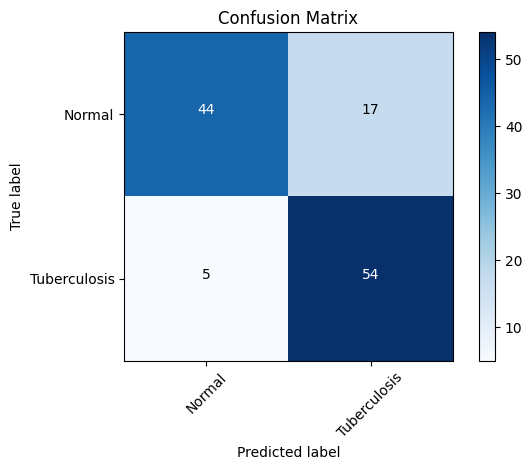

In [ ]:
# Define the labels of the class indices. These need to match the
# order shown above.
cm_plot_labels = ['Normal', 'Tuberculosis']

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

In [ ]:
# Get the filenames, labels and associated predictions

# This outputs the sequence in which the generator processed the test images
test_filenames = test_gen.filenames

# Get the true labels
y_true = test_gen.classes

# Get the predicted labels
y_pred = predictions.argmax(axis=1)

In [ ]:
from sklearn.metrics import classification_report

# Generate a classification report

report = classification_report(y_true, y_pred, target_names=cm_plot_labels)

print(report)

              precision    recall  f1-score   support

      Normal       0.90      0.72      0.80        61
Tuberculosis       0.76      0.92      0.83        59

    accuracy                           0.82       120
   macro avg       0.83      0.82      0.82       120
weighted avg       0.83      0.82      0.82       120



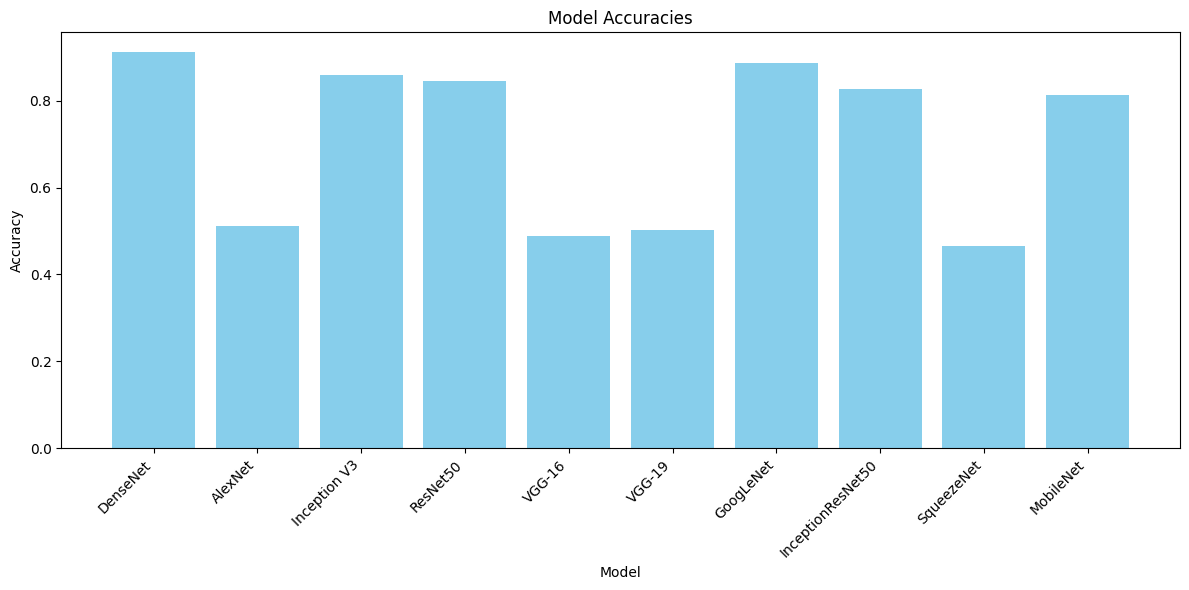

In [133]:
import matplotlib.pyplot as plt

# Define the model names and their respective accuracies
models = ['DenseNet', 'AlexNet', 'Inception V3', 'ResNet50', 'VGG-16', 'VGG-19', 'GoogLeNet', 'InceptionResNet50', 'SqueezeNet','MobileNet']
accuracies = [0.9118, 0.5118, 0.8603, 0.8456, 0.4897, 0.5029, 0.8868, 0.8279, 0.4647, 0.8132]

# Create a bar graph
plt.figure(figsize=(12, 6))
plt.bar(models, accuracies, color='skyblue')

# Add title and labels
plt.title('Model Accuracies')
plt.xlabel('Model')
plt.ylabel('Accuracy')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Display the plot
plt.tight_layout()
plt.show()
